This notebook is used to train a CNN with the UNet architecture using keras. The goal is to take DIC images of cells and generate binary masks for both the membrane and nucleus.

To separate models will be made: one for segmenting the membrane and one for segmenting the nucleus.

To train the CNN, we must use hand segmented masks and the corresponding DIC images.

##Mount Google Drive, authenticate SDK, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Installing and loading packages

In [ ]:
import pandas as pd
#pip install --upgrade pandas

In [ ]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity
from skimage import color
from skimage import exposure
import os
import numpy as np
from pathlib import Path
import re
import ntpath
import random
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageOps
import PIL
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.image import resize_with_pad
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow import keras
from tensorflow.keras import optimizers

# fix for new segmentation_models error was taken from here: https://stackoverflow.com/questions/75433717/module-keras-utils-generic-utils-has-no-attribute-get-custom-objects-when-im
os.environ["SM_FRAMEWORK"] = "tf.keras"
from segmentation_models import Unet

Segmentation Models: using `tf.keras` framework.


#Specify paths to training masks and preprocess

In [ ]:
training_masks_path='cellmbucket/cnn_training_09262023/membrane' #@param {type:"string"}
maskdir='training_masks/' #@param {type:"string"}
#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param {type:"string"}




In [ ]:
#check to see if the path exists, if not make the directory
if not os.path.exists(maskdir):
  os.mkdir(maskdir)

!gsutil -m cp -r gs://{training_masks_path}/* /{local_folder}/{maskdir}


#!mkdir {maskdir}

training_masks_folder = maskdir

Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P01_t010_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P01_t061_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P02_t054_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Stiff_P01_t002_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P01_t121_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P02_t037_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P03_t002_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P02_t117_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P03_t069_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Soft_P03_t100_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Stiff_P01_t054_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/membrane/Stiff_P01_t121_c001.tif...
Copying gs://

In [ ]:
#get names of all masks
imagenames=os.listdir(training_masks_folder)

In [ ]:
mask=imread(training_masks_folder+'/'+imagenames[0])

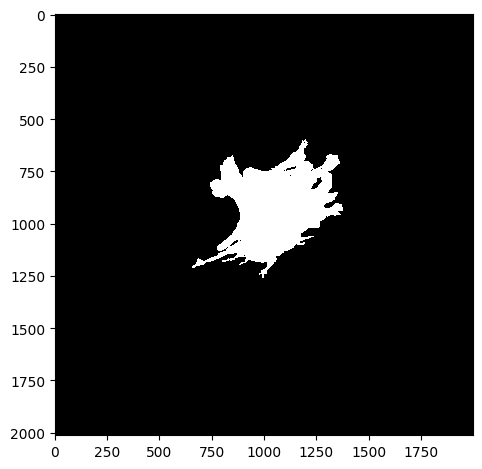

In [ ]:
imshow(mask)

In [ ]:
np.shape(mask)

(2013, 1998, 3)

In [ ]:
len(imagenames)

13

In [ ]:
#make sure masks only consist of 0 and 1's
for imagename in imagenames:
  mask=imread(maskdir+imagename)#,as_gray=True)
  #mask=color.rgb2gray(mask)
  mask[mask>0]=1
  imsave(maskdir+imagename, mask)

<ipython-input-13-e32d9e909248>:6: UserWarning: training_masks/Soft_P01_t010_c001.tif is a low contrast image
  imsave(maskdir+imagename, mask)
<ipython-input-13-e32d9e909248>:6: UserWarning: training_masks/Soft_P01_t121_c001.tif is a low contrast image
  imsave(maskdir+imagename, mask)
<ipython-input-13-e32d9e909248>:6: UserWarning: training_masks/Stiff_P01_t054_c001.tif is a low contrast image
  imsave(maskdir+imagename, mask)
<ipython-input-13-e32d9e909248>:6: UserWarning: training_masks/Stiff_P01_t002_c001.tif is a low contrast image
  imsave(maskdir+imagename, mask)
<ipython-input-13-e32d9e909248>:6: UserWarning: training_masks/Stiff_P01_t121_c001.tif is a low contrast image
  imsave(maskdir+imagename, mask)
<ipython-input-13-e32d9e909248>:6: UserWarning: training_masks/Soft_P02_t117_c001.tif is a low contrast image
  imsave(maskdir+imagename, mask)
<ipython-input-13-e32d9e909248>:6: UserWarning: training_masks/Soft_P03_t069_c001.tif is a low contrast image
  imsave(maskdir+imagen

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


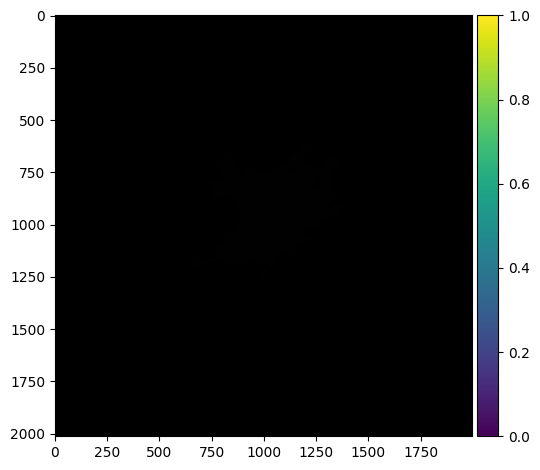

In [ ]:
#test to make sure it worked
mask=imread(maskdir+'/'+imagenames[0])
#hist=plt.hist(mask.ravel())
imshow(mask)

#Specify paths to training DIC images and preprocess

In [ ]:
training_images_path='cellmbucket/cnn_training_09262023' #@param {type:"string"}


#check to see if the path exists, if not make the directory
if not os.path.exists('imagestraining'):
  os.mkdir('imagestraining')

!gsutil -m cp -r gs://{training_images_path} /{local_folder}

imagesfolder = ntpath.basename(training_images_path)

Copying gs://cellmbucket/cnn_training_09262023/Soft_P01_t010_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P01_t121_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P01_t061_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P02_t037_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P03_t100_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P03_t002_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P03_t069_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P02_t117_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Soft_P02_t054_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Stiff_P01_t002_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Stiff_P01_t054_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Stiff_P01_t121_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/Stiff_P02_t001_c001.tif...
Copying gs://cellmbucket/cnn_training_09262023/

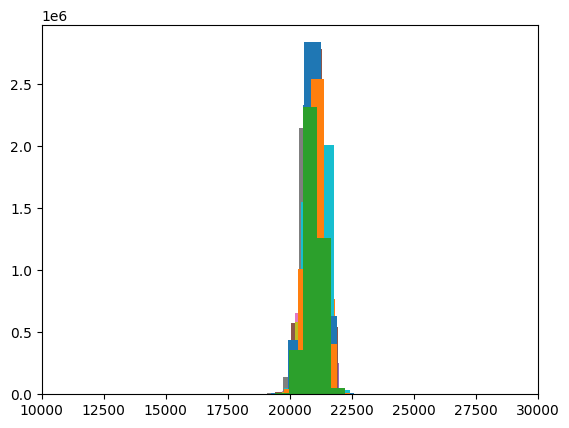

In [ ]:
for i in range(len(imagenames)):
  if imagenames[i].endswith('.tif'):
    image=imread('/'+local_folder+'/'+ imagesfolder +'/'+imagenames[i])
    plt.hist(image.ravel(),50)
  plt.xlim(10000,30000)

In [ ]:
#get images corresponding to masks, put them in 8 bit and rgb
for imagename in imagenames:
  bright = rescale_intensity(imread(imagesfolder+'/'+imagename),(18500,22500)) ###CHANGE INTENSITY BOUNDS IF NECESARRY
  #convert to 8 bit from 16 bit
  bright8b= (bright/256).astype('uint8')
  #bright8b = resize(bright8b, (bright8b.shape[0] // 4, bright8b.shape[1] // 4), anti_aliasing=True)
  #bright8b = rescale(bright8b, 0.25, anti_aliasing=False)
  #convert gray to rgb
  brigth8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
  imsave('./imagestraining/'+imagename, brigth8b_rgb)
  #imsave('./imagestraining/'+imagename, bright)

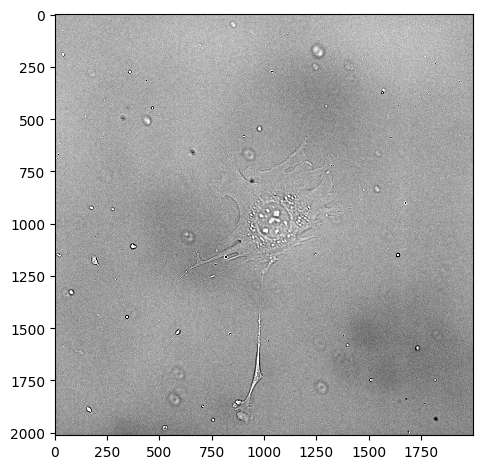

In [ ]:
image=imread('imagestraining/'+imagenames[0])
imshow(image)

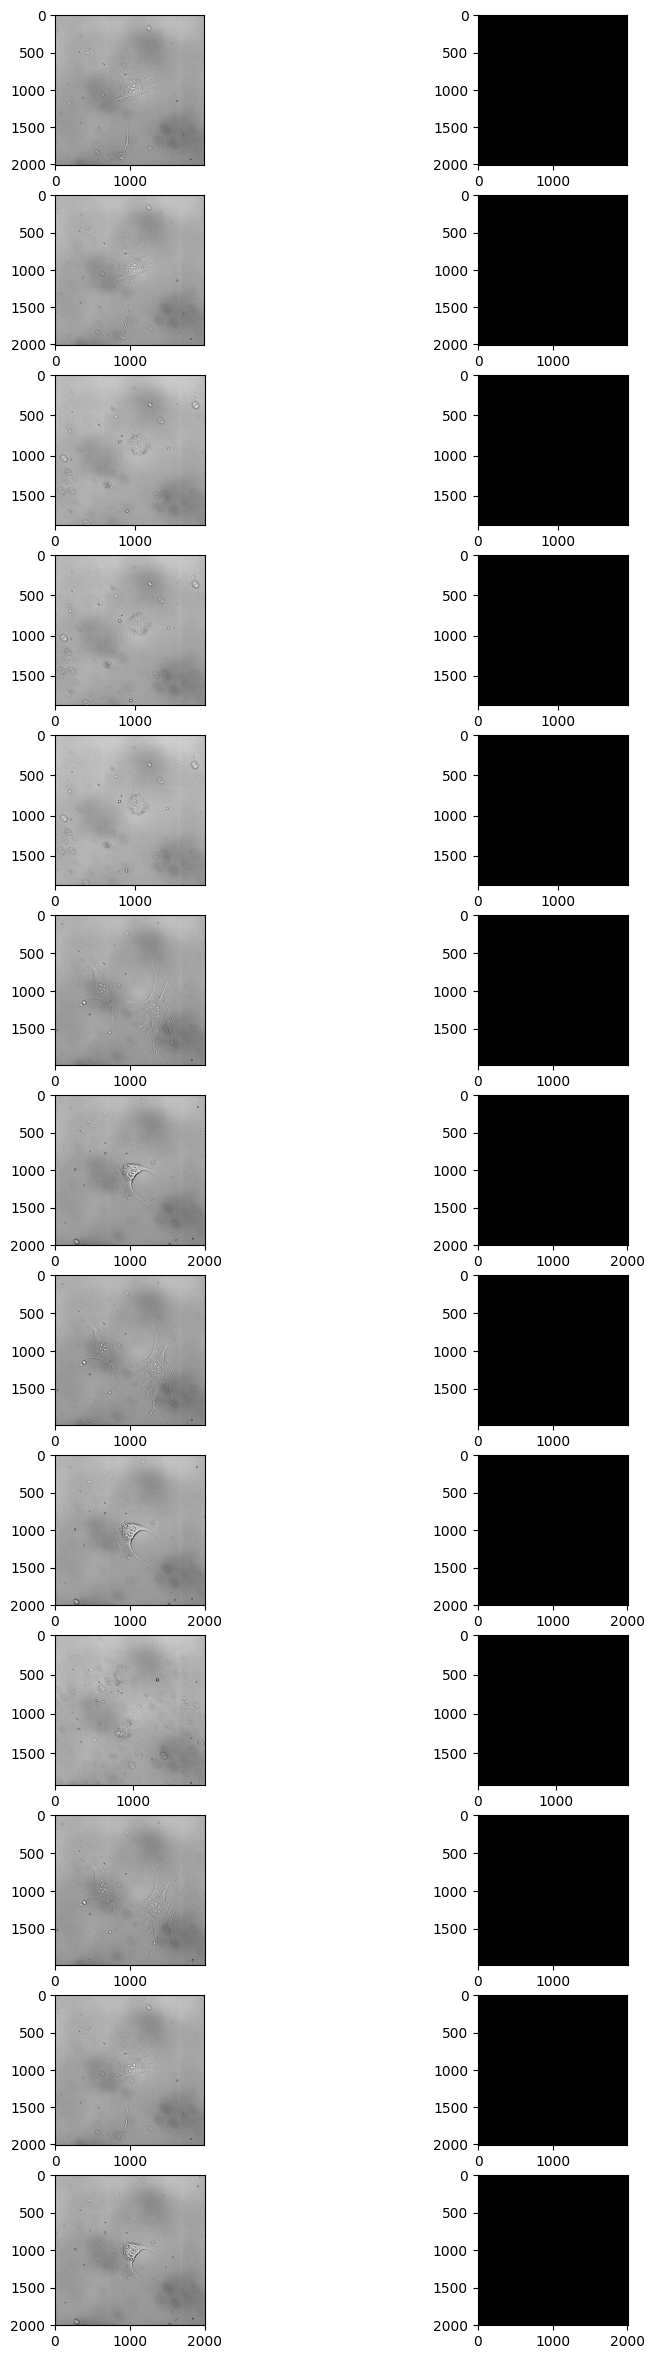

In [ ]:
f, axarr = plt.subplots(len(imagenames),2)
for i in range(len(imagenames)):
  mask=imread(maskdir+'/'+imagenames[i])
  image=imread('imagestraining/'+imagenames[i])

  axarr[i,0].imshow(image)
  axarr[i,1].imshow(mask)
  f.set_size_inches(10,30)

#Augment and Pad Data

In [ ]:
#pads an array to make it a sqaure
#if the array is already a square it doesn't pad
def pad_with_zeros_to_square(img,mask):
  x_dim = np.shape(img)[0]
  y_dim = np.shape(img)[1]

  diff = x_dim - y_dim

  if diff < 0:
    pad_img = np.pad(img, ((0, np.abs(diff)),(0,0),(0,0)),'constant', constant_values=0)
    pad_mask = np.pad(mask, ((0, np.abs(diff)),(0,0),(0,0)),'constant', constant_values=0)
  if diff > 0:
    pad_img = np.pad(img, ((0, 0),(0,np.abs(diff)),(0,0)),'constant', constant_values=0)
    pad_mask = np.pad(mask, ((0, 0),(0,np.abs(diff)),(0,0)),'constant', constant_values=0)
  elif diff == 0:
    pad_img = img
    pad_mask = mask
  return pad_img, pad_mask

In [ ]:
def augment(image_name, aug_img_dir, aug_mask_dir):
  image=imread('imagestraining/'+image_name)
  mask=imread(maskdir+'/'+image_name)

  image, mask = pad_with_zeros_to_square(image,mask)

  # image_pil = Image.open('imagestraining/'+image_name)
  # mask_pil = Image.open(maskdir+'/'+image_name)

  imglr = np.fliplr(image)
  masklr = np.fliplr(mask)
  imgud = np.flipud(image)
  maskud = np.flipud(mask)

  img_brt_p5 = exposure.adjust_gamma(image, gamma=0.5)
  img_brt_p25 = exposure.adjust_gamma(image, gamma=0.25)
  img_brt_p75 = exposure.adjust_gamma(image, gamma=0.75)
  img_drk_1p5 = exposure.adjust_gamma(image, gamma=1.5)
  img_drk_1p25 = exposure.adjust_gamma(image, gamma=1.25)
  img_drk_1p75 = exposure.adjust_gamma(image, gamma=1.75)

  imglr_brt_p5 = np.fliplr(img_brt_p5)
  imglr_brt_p25 = np.fliplr(img_brt_p25)
  imglr_brt_p75 = np.fliplr(img_brt_p75)
  imgud_brt_p5 = np.flipud(img_brt_p5)
  imgud_brt_p25 = np.flipud(img_brt_p25)
  imgud_brt_p75 = np.flipud(img_brt_p75)
  imglr_drk_1p5 = np.fliplr(img_drk_1p5)
  imglr_drk_1p25 = np.fliplr(img_drk_1p25)
  imglr_drk_1p75 = np.fliplr(img_drk_1p75)
  imgud_drk_1p5 = np.flipud(img_drk_1p5)
  imgud_drk_1p25 = np.flipud(img_drk_1p25)
  imgud_drk_1p75 = np.flipud(img_drk_1p75)

#####################################################

  # imglr_pil = Image.fromarray(imglr)
  # masklr_pil = Image.fromarray(masklr)
  # imgud_pil = Image.fromarray(imgud)
  # maskud_pil = Image.fromarray(maskud)

  # imgrot45 = image_pil.rotate(45)
  # maskrot45 = mask_pil.rotate(45)
  # imgrot225 = image_pil.rotate(225)
  # maskrot225 = mask_pil.rotate(225)

  # imglrrot45 = imglr_pil.rotate(45)
  # masklrrot45 = masklr_pil.rotate(45)
  # imglrrot225 = imglr_pil.rotate(225)
  # masklrrot225 = masklr_pil.rotate(225)

  # imgudrot45 = imgud_pil.rotate(45)
  # maskudrot45 = maskud_pil.rotate(45)
  # imgudrot225 = imgud_pil.rotate(225)
  # maskudrot225 = maskud_pil.rotate(225)
###################################################
  # imgrot45 = rotate(image, 45)
  # maskrot45 = rotate(mask,45)
  # imgrot225 = rotate(image, 225)
  # maskrot225 = rotate(mask,225)

  # imglrrot45 = rotate(imglr, 45)
  # masklrrot45 = rotate(masklr,45)
  # imglrrot225 = rotate(imglr, 225)
  # masklrrot225 = rotate(masklr,225)

  # imgudrot45 = rotate(imgud, 45)
  # maskudrot45 = rotate(maskud,45)
  # imgudrot225 = rotate(imgud, 225)
  # maskudrot225 = rotate(maskud,225)

  imsave(aug_img_dir+'/'+image_name, image)
  imsave(aug_mask_dir+'/'+image_name, mask)
  imsave(aug_img_dir+'/lr_'+image_name, imglr)
  imsave(aug_mask_dir+'/lr_'+image_name, masklr)
  imsave(aug_img_dir+'/ud_'+image_name, imgud)
  imsave(aug_mask_dir+'/ud_'+image_name, maskud)

  imsave(aug_img_dir+'/bright_p5_'+image_name, img_brt_p5)
  imsave(aug_mask_dir+'/bright_p5_'+image_name, mask)
  imsave(aug_img_dir+'/bright_p25_'+image_name, img_brt_p25)
  imsave(aug_mask_dir+'/bright_p25_'+image_name, mask)
  imsave(aug_img_dir+'/bright_p75_'+image_name, img_brt_p75)
  imsave(aug_mask_dir+'/bright_p75_'+image_name, mask)
  imsave(aug_img_dir+'/dark_1p5_'+image_name, img_drk_1p5)
  imsave(aug_mask_dir+'/dark_1p5_'+image_name, mask)
  imsave(aug_img_dir+'/dark_1p25_'+image_name, img_drk_1p25)
  imsave(aug_mask_dir+'/dark_1p25_'+image_name, mask)
  imsave(aug_img_dir+'/dark_1p75_'+image_name, img_drk_1p75)
  imsave(aug_mask_dir+'/dark_1p75_'+image_name, mask)

  imsave(aug_img_dir+'/lrbright_p5_'+image_name, imglr_brt_p5)
  imsave(aug_mask_dir+'/lrbright_p5_'+image_name, masklr)
  imsave(aug_img_dir+'/lrbright_p25_'+image_name, imglr_brt_p25)
  imsave(aug_mask_dir+'/lrbright_p25_'+image_name, masklr)
  imsave(aug_img_dir+'/lrbright_p75_'+image_name, imglr_brt_p75)
  imsave(aug_mask_dir+'/lrbright_p75_'+image_name, masklr)
  imsave(aug_img_dir+'/udbright_p5_'+image_name, imgud_brt_p5)
  imsave(aug_mask_dir+'/udbright_p5_'+image_name, maskud)
  imsave(aug_img_dir+'/udbright_p25_'+image_name, imgud_brt_p25)
  imsave(aug_mask_dir+'/udbright_p25_'+image_name, maskud)
  imsave(aug_img_dir+'/udbright_p75_'+image_name, imgud_brt_p75)
  imsave(aug_mask_dir+'/udbright_p75_'+image_name, maskud)

  imsave(aug_img_dir+'/lrdark_1p5_'+image_name, imglr_drk_1p5)
  imsave(aug_mask_dir+'/lrdark_1p5_'+image_name, masklr)
  imsave(aug_img_dir+'/lrdark_1p25_'+image_name, imglr_drk_1p25)
  imsave(aug_mask_dir+'/lrdark_1p25_'+image_name, masklr)
  imsave(aug_img_dir+'/lrdark_1p75_'+image_name, imglr_drk_1p75)
  imsave(aug_mask_dir+'/lrdark_1p75_'+image_name, masklr)
  imsave(aug_img_dir+'/uddark_1p5_'+image_name, imgud_drk_1p5)
  imsave(aug_mask_dir+'/uddark_1p5_'+image_name, maskud)
  imsave(aug_img_dir+'/uddark_1p25_'+image_name, imgud_drk_1p25)
  imsave(aug_mask_dir+'/uddark_1p25_'+image_name, maskud)
  imsave(aug_img_dir+'/uddark_1p75_'+image_name, imgud_drk_1p75)
  imsave(aug_mask_dir+'/uddark_1p75_'+image_name, maskud)
#####################################################
  # imgrot45.save(aug_img_dir+'/rot45_'+image_name)
  # maskrot45.save(aug_mask_dir+'/rot45_'+image_name)
  # imgrot225.save(aug_img_dir+'/rot225_'+image_name)
  # maskrot225.save(aug_mask_dir+'/rot225_'+image_name)

  # imglrrot45.save(aug_img_dir+'/lrrot45_'+image_name)
  # masklrrot45.save(aug_mask_dir+'/lrrot45_'+image_name)
  # imglrrot225.save(aug_img_dir+'/lrrot225_'+image_name)
  # masklrrot225.save(aug_mask_dir+'/lrrot225_'+image_name)

  # imgudrot45.save(aug_img_dir+'/udrot45_'+image_name)
  # maskudrot45.save(aug_mask_dir+'/udrot45_'+image_name)
  # imgudrot225.save(aug_img_dir+'/udrot225_'+image_name)
  # maskudrot225.save(aug_mask_dir+'/udrot225_'+image_name)
#######################################################
  # imsave(aug_img_dir+'/rot45_'+image_name, imgrot45)
  # imsave(aug_mask_dir+'/rot45_'+image_name, maskrot45)
  # imsave(aug_img_dir+'/rot225_'+image_name, imgrot225)
  # imsave(aug_mask_dir+'/rot225_'+image_name, maskrot225)

  # imsave(aug_img_dir+'/lrrot45_'+image_name, imglrrot45)
  # imsave(aug_mask_dir+'/lrrot45_'+image_name, masklrrot45)
  # imsave(aug_img_dir+'/lrrot225_'+image_name, imglrrot225)
  # imsave(aug_mask_dir+'/lrrot225_'+image_name, masklrrot225)

  # imsave(aug_img_dir+'/udrot45_'+image_name, imgudrot45)
  # imsave(aug_mask_dir+'/udrot45_'+image_name, maskudrot45)
  # imsave(aug_img_dir+'/udrot225_'+image_name, imgudrot225)
  # imsave(aug_mask_dir+'/udrot225_'+image_name, maskudrot225)

In [ ]:
aug_imagestraining = 'aug_imagestraining'
aug_trainingmasks = 'aug_trainingmasks'

In [ ]:
!mkdir {aug_imagestraining}
!mkdir {aug_trainingmasks}

mkdir: cannot create directory ‘aug_imagestraining’: File exists
mkdir: cannot create directory ‘aug_trainingmasks’: File exists


In [ ]:
for i in range(len(imagenames)):
  augment(imagenames[i],aug_imagestraining, aug_trainingmasks)

<ipython-input-26-ee23d0b423f0>:73: UserWarning: aug_trainingmasks/Soft_P01_t010_c001.tif is a low contrast image
  imsave(aug_mask_dir+'/'+image_name, mask)
<ipython-input-26-ee23d0b423f0>:75: UserWarning: aug_trainingmasks/lr_Soft_P01_t010_c001.tif is a low contrast image
  imsave(aug_mask_dir+'/lr_'+image_name, masklr)
<ipython-input-26-ee23d0b423f0>:77: UserWarning: aug_trainingmasks/ud_Soft_P01_t010_c001.tif is a low contrast image
  imsave(aug_mask_dir+'/ud_'+image_name, maskud)
<ipython-input-26-ee23d0b423f0>:80: UserWarning: aug_trainingmasks/bright_p5_Soft_P01_t010_c001.tif is a low contrast image
  imsave(aug_mask_dir+'/bright_p5_'+image_name, mask)
<ipython-input-26-ee23d0b423f0>:82: UserWarning: aug_trainingmasks/bright_p25_Soft_P01_t010_c001.tif is a low contrast image
  imsave(aug_mask_dir+'/bright_p25_'+image_name, mask)
<ipython-input-26-ee23d0b423f0>:84: UserWarning: aug_trainingmasks/bright_p75_Soft_P01_t010_c001.tif is a low contrast image
  imsave(aug_mask_dir+'/bri

In [ ]:
aug_imagenames=os.listdir(aug_trainingmasks)

In [ ]:
len(aug_imagenames)

273

In [ ]:
f, axarr = plt.subplots(len(aug_imagenames),2)
for i in range(len(aug_imagenames)):
  mask=imread(aug_trainingmasks+'/'+aug_imagenames[i])
  image=imread(aug_imagestraining+'/'+aug_imagenames[i])

  axarr[i,0].imshow(image)
  axarr[i,1].imshow(mask)
  f.set_size_inches(20,100)

#Set up model training

In [ ]:
#@markdown specify the desired height and width to resize the images to be input to the model
img_height=1024 #@param {type:"integer"}
img_width=1024 #@param {type:"integer"}

In [ ]:
input_dir = "/content/aug_imagestraining"
target_dir = "/content/aug_trainingmasks"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".tif")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)



Number of samples: 273
/content/aug_imagestraining/Soft_P01_t010_c001.tif | /content/aug_trainingmasks/Soft_P01_t010_c001.tif
/content/aug_imagestraining/Soft_P01_t061_c001.tif | /content/aug_trainingmasks/Soft_P01_t061_c001.tif
/content/aug_imagestraining/Soft_P01_t121_c001.tif | /content/aug_trainingmasks/Soft_P01_t121_c001.tif
/content/aug_imagestraining/Soft_P02_t037_c001.tif | /content/aug_trainingmasks/Soft_P02_t037_c001.tif
/content/aug_imagestraining/Soft_P02_t054_c001.tif | /content/aug_trainingmasks/Soft_P02_t054_c001.tif
/content/aug_imagestraining/Soft_P02_t117_c001.tif | /content/aug_trainingmasks/Soft_P02_t117_c001.tif
/content/aug_imagestraining/Soft_P03_t002_c001.tif | /content/aug_trainingmasks/Soft_P03_t002_c001.tif
/content/aug_imagestraining/Soft_P03_t069_c001.tif | /content/aug_trainingmasks/Soft_P03_t069_c001.tif
/content/aug_imagestraining/Soft_P03_t100_c001.tif | /content/aug_trainingmasks/Soft_P03_t100_c001.tif
/content/aug_imagestraining/Stiff_P01_t002_c001.ti

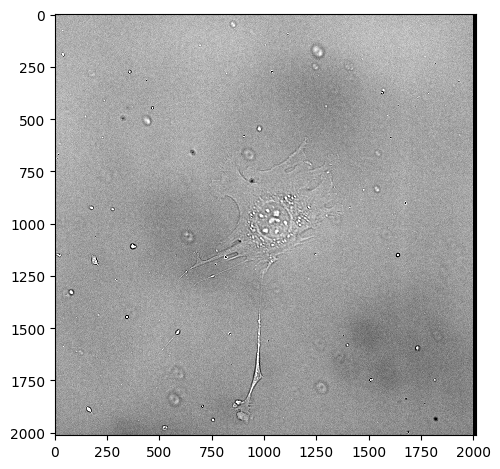

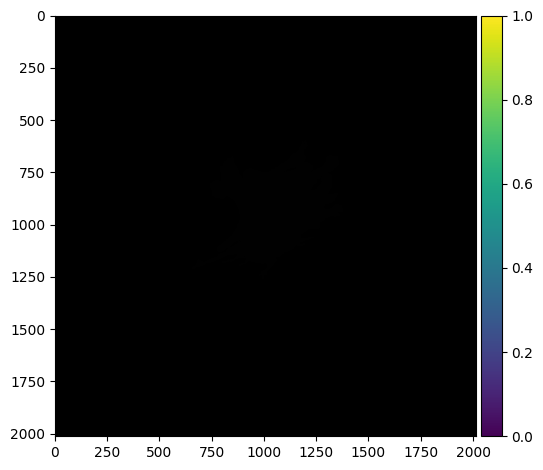

In [ ]:
# Display input image #0
plt.figure()
imshow(input_img_paths[0])

# Display auto-contrast version of corresponding target (per-pixel categories)
plt.figure()
imshow(target_img_paths[0])


In [ ]:
class CellSegmenter(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='rgb')
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [ ]:
img_size = (img_height, img_width) #(1024, 1024)
num_classes = 2
batch_size = 2

In [ ]:
# Split our img paths into a training and a validation set
val_samples = 50
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = CellSegmenter(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = CellSegmenter(batch_size, img_size, val_input_img_paths, val_target_img_paths)


##Run if starting from scratch

In [ ]:
model = Unet('resnet34', encoder_weights='imagenet', classes=2, input_shape=img_size + (3,), activation='softmax')
model.summary()

85521592/85521592 [==============================] - 35s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 1024, 1024, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 1030, 1030, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                          

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

##Run if training existing model

In [ ]:
#@markdown Path model is saved on GCP
model_save_path = 'cellmbucket/keras_unet_model/nucleus_segmenter_04262023_1024x1024imagesize' #@param {type:"string"}
!gsutil -m cp gs://{model_save_path} .

Copying gs://cellmbucket/keras_unet_model/nucleus_segmenter_04262023_1024x1024imagesize...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1/1 files][187.1 MiB/187.1 MiB] 100% Done                                    
Operation completed over 1 objects/187.1 MiB.                                    


In [ ]:
model = keras.models.load_model(ntpath.basename(model_save_path))

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

#Begin training

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/5
111/111 [==============================] - 65s 582ms/step - loss: 0.0067 - val_loss: 0.0126
Epoch 2/5
111/111 [==============================] - 78s 693ms/step - loss: 0.0064 - val_loss: 0.0126
Epoch 3/5
111/111 [==============================] - 66s 593ms/step - loss: 0.0060 - val_loss: 0.0103
Epoch 4/5
111/111 [==============================] - 71s 641ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 5/5
111/111 [==============================] - 66s 597ms/step - loss: 0.0054 - val_loss: 0.0090


In [ ]:
val_input_img_paths[10]

'/content/aug_imagestraining/udbright_p25_Stiff_P01_t054_c001.tif'

25/25 [==============================] - 6s 244ms/step


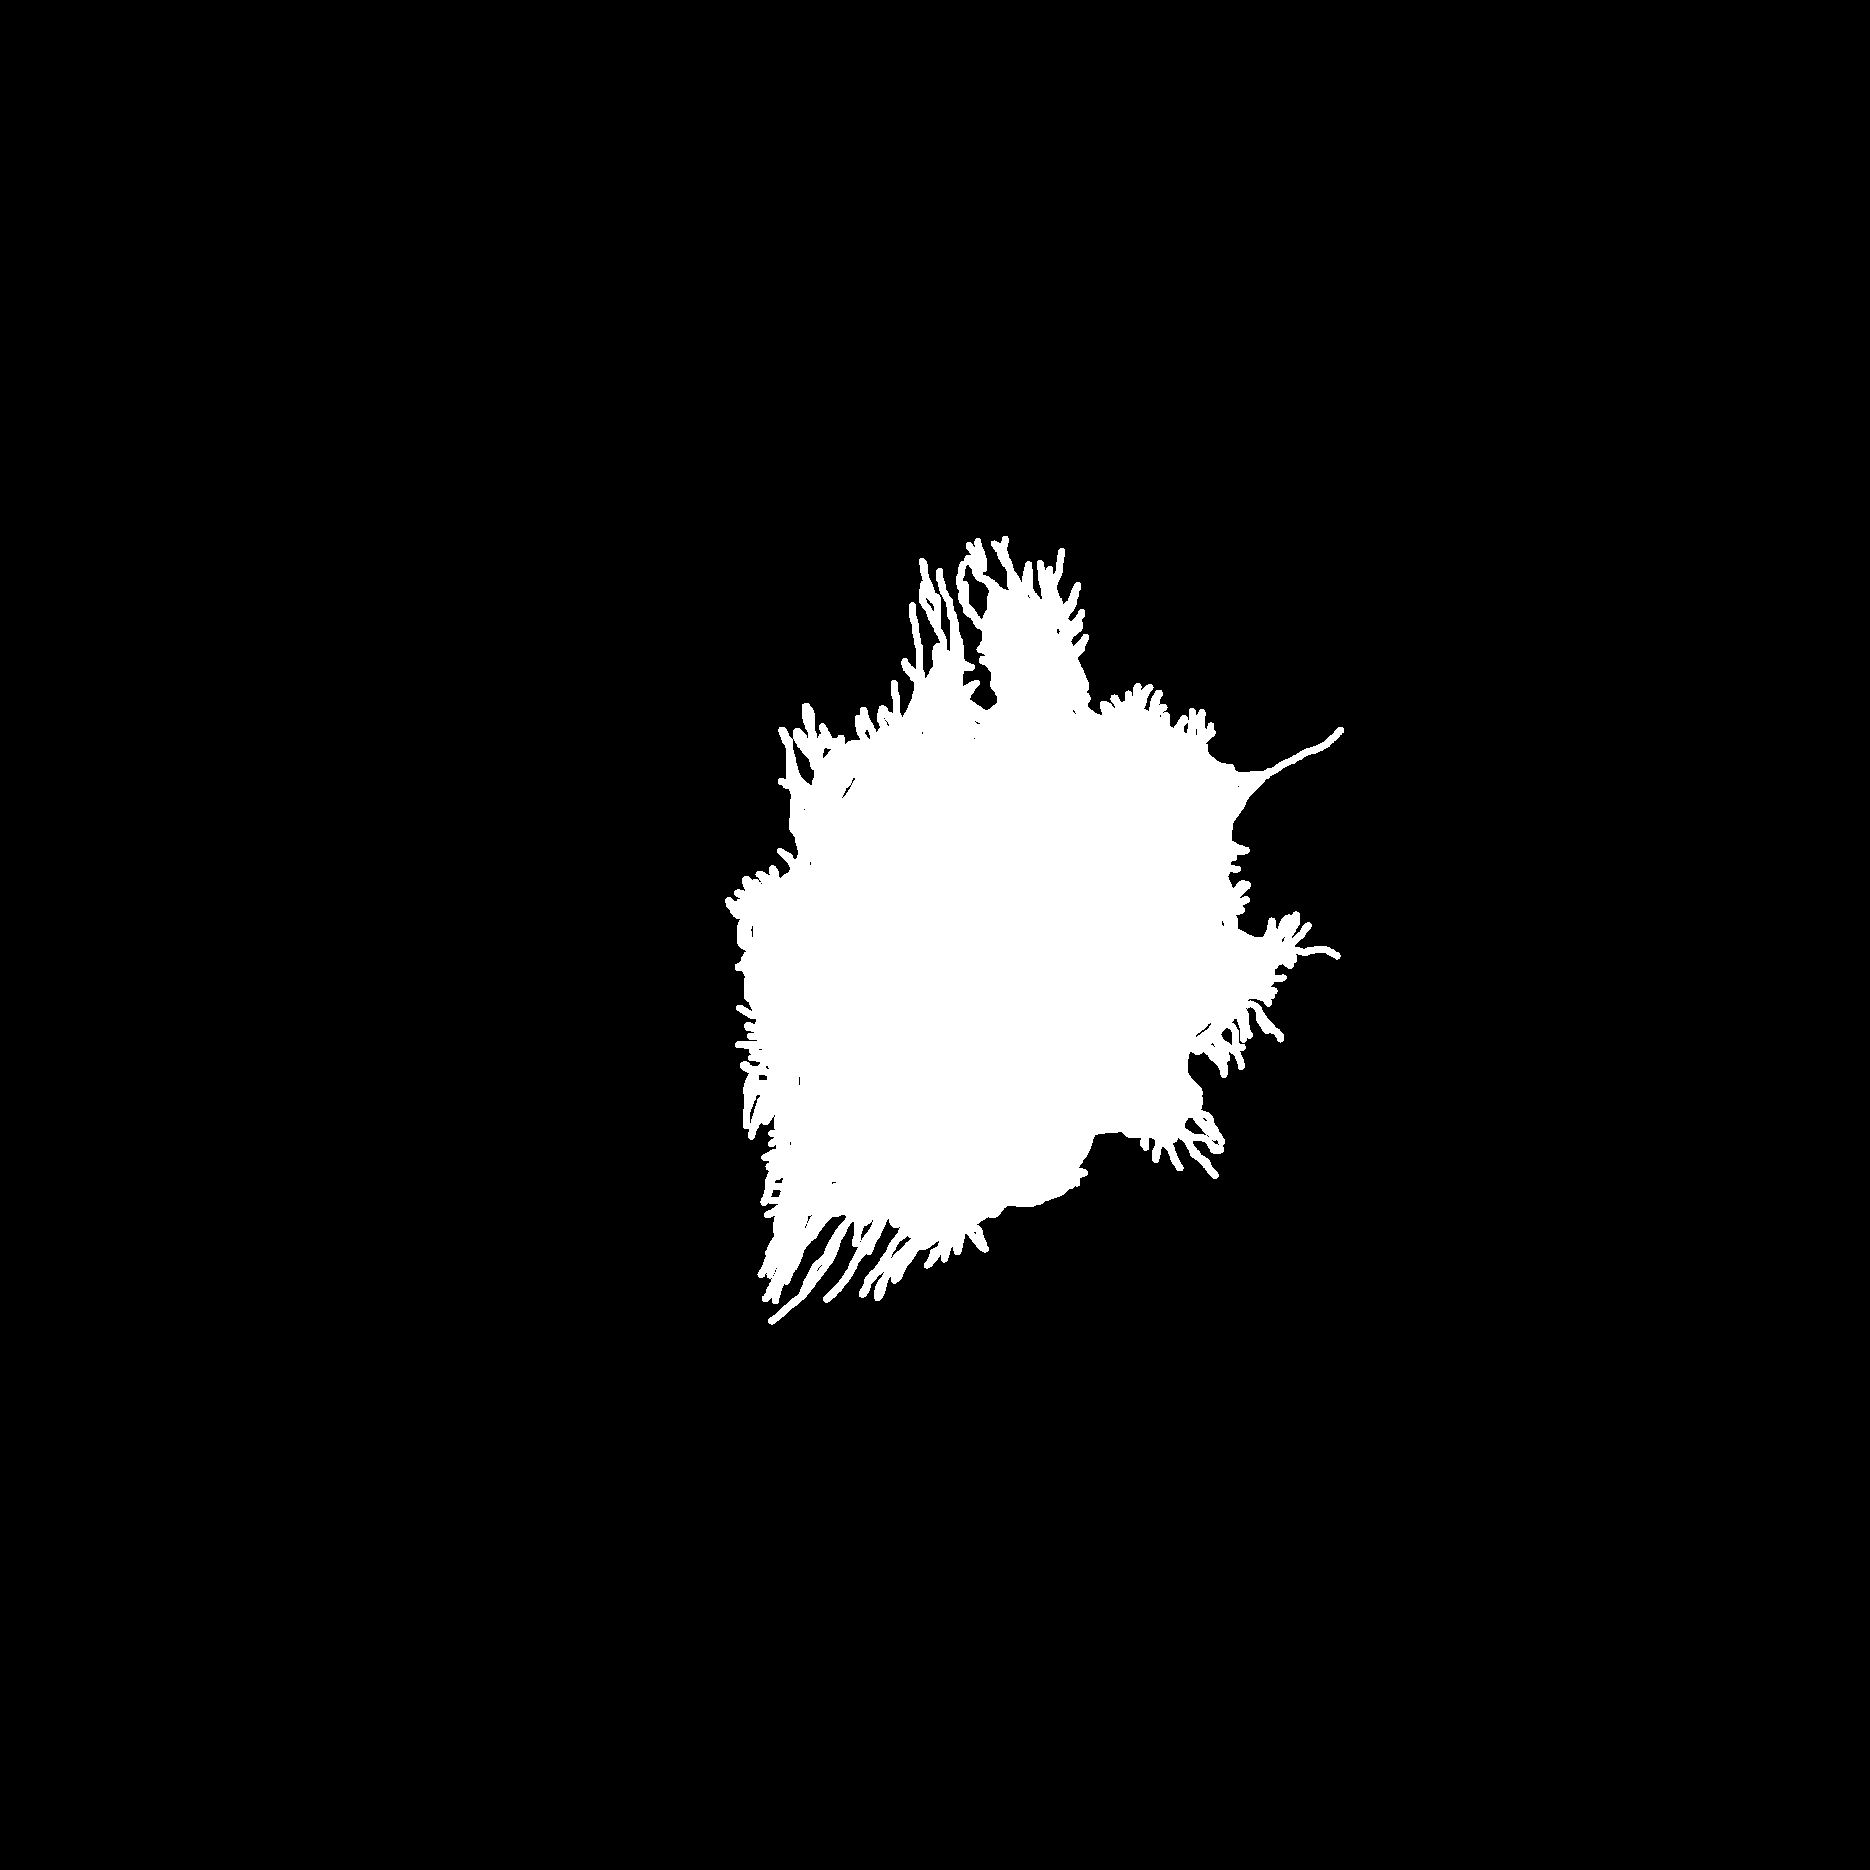

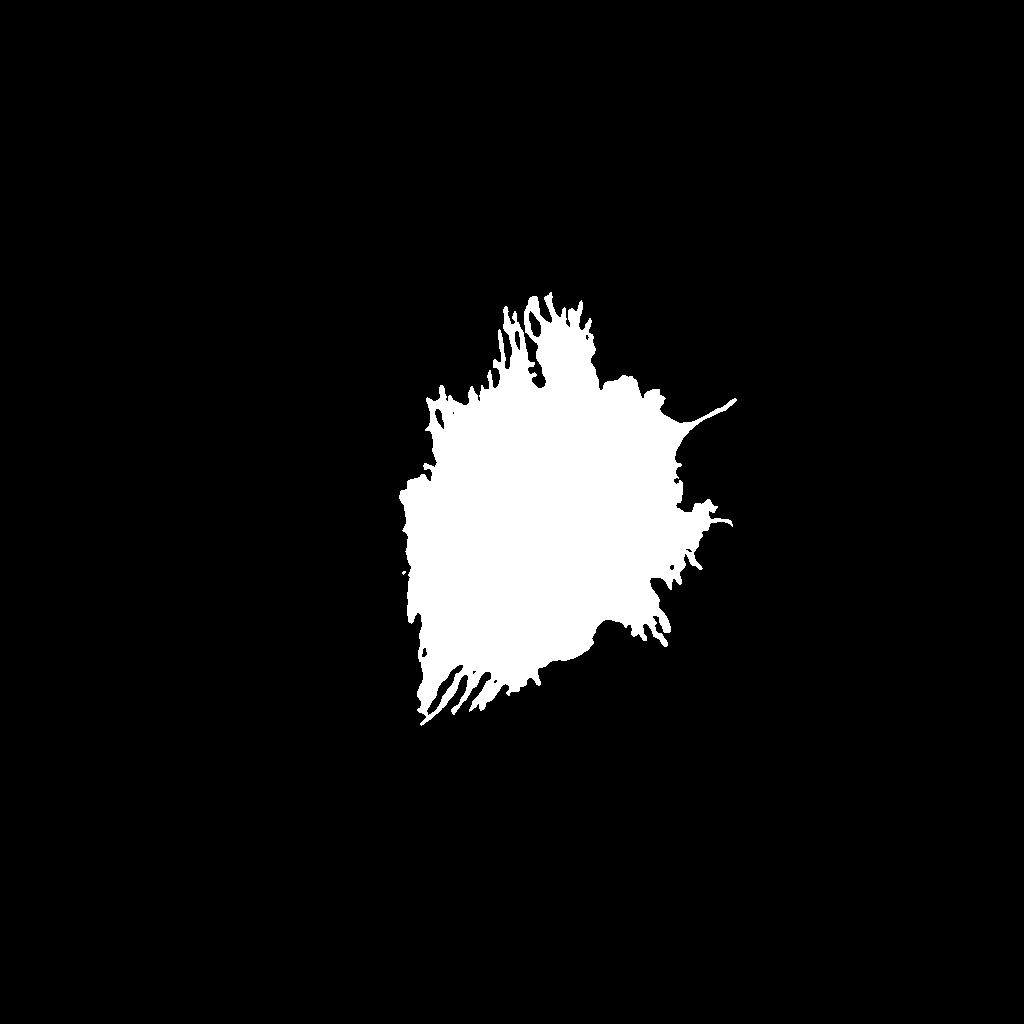

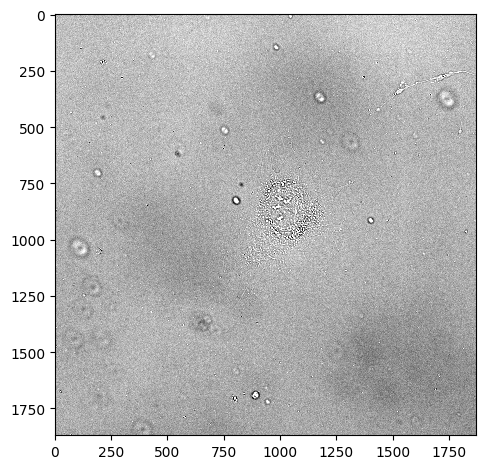

In [ ]:
# Generate predictions for all images in the validation set

val_gen = CellSegmenter(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #8
i = 1

# Display input image
imshow(val_input_img_paths[i])

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.


#Save model

In [ ]:
#@markdown Name to save trained model
model_name='membrane_segmenter_10052023_1024x1024imagesize' #@param {type:"string"}

In [ ]:
#@markdown Path to save model on GCP
save_path = 'cellmbucket/keras_unet_model/protrusion_retraction_project' #@param {type:"string"}

In [ ]:
# model_config = { "class_name": "Model",
#                      "config":model.get_config()
#                      }


json_name = model_name+'_model_config.json'
weights_name = model_name+'_weights_only.h5'

# Save model config
json_config = model.to_json()
with open(json_name, 'w') as json_file:
  json_file.write(json_config)

# Save weights and architecture
model.save_weights(weights_name)

In [ ]:
!gsutil cp /{local_folder}/{json_name} gs://{save_path}

Copying file:///content/membrane_segmenter_10052023_1024x1024imagesize_model_config.json [Content-Type=application/json]...
/ [1 files][118.7 KiB/118.7 KiB]                                                
Operation completed over 1 objects/118.7 KiB.                                    


In [ ]:
!gsutil cp /{local_folder}/{weights_name} gs://{save_path}

Copying file:///content/membrane_segmenter_10052023_1024x1024imagesize_weights_only.h5 [Content-Type=application/x-hdf5]...
/ [1 files][ 93.7 MiB/ 93.7 MiB]                                                
Operation completed over 1 objects/93.7 MiB.                                     


###old way of saving model

In [ ]:
model.save(model_name, save_format="h5")

In [ ]:
!gsutil -m cp {model_name} gs://{save_path}

Copying file://nucleus_segmenter_06302023_1024x1024imagesize [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1/1 files][187.1 MiB/187.1 MiB] 100% Done                                    
Operation completed over 1 objects/187.1 MiB.                                    
